# Quantum-enhanced Monte Carlo markov chain optimization

The combination of classical Monte Carlo Markov chains (MCMC) methods with quantum computers showed potential for achieving quantum advantage in sampling from complex probability distributions, a computationally hard task arising in many diverse fields [1]. Quantum-enhanced proposal distributions, defined by parameterized unitaries, could outperform classical strategies in proposing effective moves in MCMC. However, it is crucial to carefully tune the values of the parameters defining the quantum proposal distribution, as they determine the resulting advantage over the classical counterpart. A general optimization method becomes essential when considering problems where is not possible to identify a reasonable parameter set. This could happen when adopting complicated proposal strategies depending on a large number of parameters, or simply when no prior or relevant information about the problem is available.

In the following, a general optimization approach that exploits estimates of the autocorrelation function of a certain observable, calculated over a set of samples, to optimize the parameters defining the quantum proposal distribution is presented. In order to analyze the performance of the optimization algorithm, state vector simulations on a classical computer are run, monitoring the spectral gap $\delta$ and the cost function value during the optimization.




*REFERENCES*

[1] David Layden et al., “Quantum-enhanced Markov chain Monte Carlo”, AirXiv (2022),
doi: 10.48550/ARXIV.2203.12497, url: https://arxiv.org/abs/2203.12497

#### Imports

In [16]:
import numpy
import scipy
import matplotlib.pyplot as plt

from q_systems import SpinSystem
from qmcmc_classes import *

#### Defining the energy model



          MODEL : 2D_Ising_random_mean_0_sd_1
Non-zero Interactions (J) : 10 / 10
Non-zero Bias (h) : 5 / 5
------------------------------------------------------------
Average Interaction Strength <|J|>:  1.18
Average Bias Strength <|h|>:  0.583
------------------------------------------------------------


Spins coupling heatmap: 



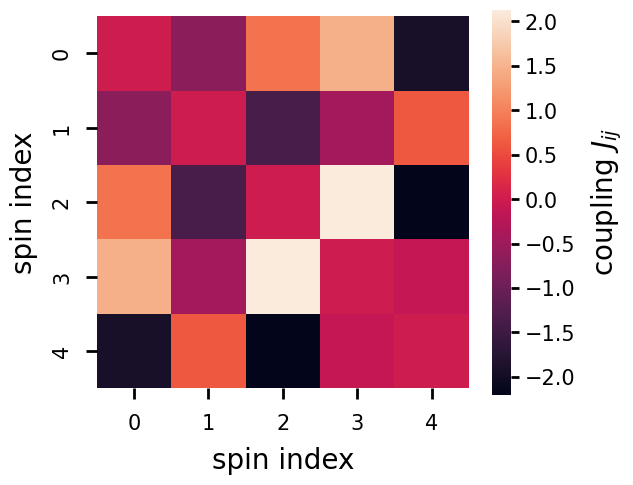

In [18]:
# number of spins
n_spins = 5
# temperature
T = 10
# random seed 
# numpy.random.seed(630201)
# model instance
model_instance = IsingModel_2D(n_spins, random=True)
J = model_instance.J  # couplings 
h = model_instance.h  # fields
# initialize spin system
spin_system = SpinSystem(n_spins, T, J, h)
# printing model summary
model_instance.summary(plot=True)

#### Setting up the QMCMC optimizer 

In [19]:
# ansatz class
ansatz = IBM_Ansatz 
# length of the chains used to gather the samples and evaluate the cost function
mc_length = 2000
# number of initial samples to discard
discard = n_spins*1e3
# cost function
cost_f_choice = 'ACF'
lag = 'integral'
#
average_over = 1  #TODO: remove
# initial parameters guess
params_dict = {'gamma': 0.16, 'tau': 2}
# observable 
observable = 'energy'
# optimization approach
optimization_approach = 'concatenated_mc'
# initializing the QMCMC optimizer
qmcmc_optimizer = QMCMC_Optimizer(spin_system, ansatz, mc_length, average_over=average_over,
                   cost_f_choice=cost_f_choice, optimization_approach=optimization_approach,
                   verbose=True, initial_transient=discard, observable=observable, lag=lag)



Discarded 5000 samples



#### Setting up classical optimizer

In [20]:
# optimization boundaries
bnds = ((0.1, 1), (1, 10))
# minimization algorithm
optimizer ='Nelder-Mead'
# define initial simplex
# initial_simplex = array_like of shape (N + 1, N)
# accuracy
# fatol =  float
# max size of the simplex
# xatol =  float
# max number of iterations per optimization cycle
# maxiter = int

#### Optimizing the quantum proposal distribution

In [21]:
# saving initial parameters guess in a string
params_guess = numpy.fromiter(params_dict.values(), dtype=float)
params_string = '_'
for param_name, value in params_dict.items():
    params_string += param_name + f'_{round(value, 3)}_'
# include the initial params values and corresponding spectral gap value in the DataFrame containing
# the optimization results
# cost_f = qmcmc_optimizer(params_guess, qmcmc_optimizer.current_state)
# qmcmc_optimizer.get_save_results(params=params_guess, cost_f=cost_f)

In [22]:
while data_to_collect(qmcmc_optimizer, max_iteration=35e3): 

    # saving the current state (used when optimization_approach='same_start_mc')
    args = (qmcmc_optimizer.current_state)
    # minimizing the cost funciton
    results = scipy.optimize.minimize(qmcmc_optimizer, x0=params_guess, args=args, 
                  method=optimizer, bounds=bnds, options = {
                  'adaptive': True if params_guess.size > 3 else False, 'initial_simplex': None})
    # updating the parameters guess
    params_guess = results.x
    # optimizing lag value
    if isinstance(qmcmc_optimizer.lag, dict):
        qmcmc_optimizer.optimize_lag()
    # saving the current results
    qmcmc_optimizer.get_save_results(results=results)

# printing out termination message
print('\nOptimization terminated with:', qmcmc_optimizer.iteration, 'cost function evaluations\n')



----------        Current sgap value: 0.008, params values: [0.15954748 1.88432463]        ----------


----------        Current sgap value: 0.009, params values: [0.16149618 1.93139536]        ----------


----------        Current sgap value: 0.009, params values: [0.15468306 2.02192952]        ----------


----------        Current sgap value: 0.01, params values: [0.16485938 2.03298099]        ----------


----------        Current sgap value: 0.011, params values: [0.16911363 2.06288816]        ----------


----------        Current sgap value: 0.011, params values: [0.16699971 2.11446037]        ----------


----------        Current sgap value: 0.013, params values: [0.1742918  2.21323612]        ----------


----------        Current sgap value: 0.014, params values: [0.17755977 2.1994034 ]        ----------


----------        Current sgap value: 0.011, params values: [0.16784483 2.12382287]        ----------


----------        Current sgap value: 0.011, params values: [0.1

#### Saving the results in a file

In [ ]:
# saving the results
# csv_name = 'QMCMC_optimization_' + params_string + '.csv'
# qmcmc_optimizer.db.to_csv(csv_name, encoding='utf-8')
# print('\nSaved results to csv file: ' + csv_name + '\n')

#### Plotting the results

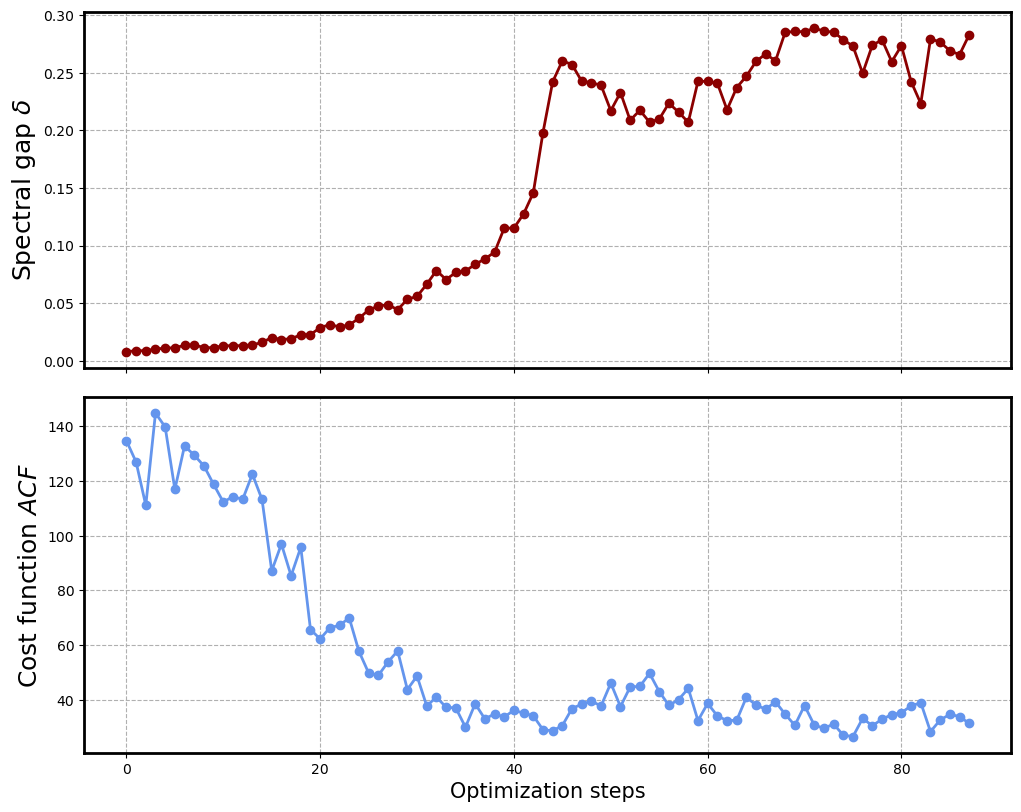

In [23]:
# converting the DataFrame containing the result in numpy arrays
spectral_gap = numpy.array(qmcmc_optimizer.db['spectral gap'])
cost_function = numpy.array(qmcmc_optimizer.db['cost f'])
# plotting the results
figure, axis = plt.subplots((2), figsize=(10, 8), dpi=100)
figure.tight_layout(h_pad=0, w_pad=4)  # spacing between subplots
# spectral gap
axis[0].plot(range(spectral_gap.size), spectral_gap, marker='o', color='darkred',
                  label='$\delta$', linestyle='-', lw=2)
axis[0].grid(linestyle='--')
axis[0].set_xticklabels([])
axis[0].set_ylabel('Spectral gap $\delta$', fontsize=18)
#axis[0][0].set_ylim(0, 1)
for ax in ['top','bottom','left','right']:
    axis[0].spines[ax].set_linewidth(2)
# cost function
axis[1].plot(range(cost_function.size), cost_function, marker='o', color='cornflowerblue',
                  label='cost function', linestyle='-', lw=2)
axis[1].grid(linestyle='--')
axis[1].set_xlabel('Optimization steps', fontsize=15)
axis[1].set_ylabel('Cost function $' + cost_f_choice + '$', fontsize=18)
for ax in ['top','bottom','left','right']:
    axis[1].spines[ax].set_linewidth(2)